# Calculate activity with pycalphad

Set up the database

In [2]:
from pycalphad import Database, equilibrium, variables as v
import numpy as np

# Database from Zhou, C., Guo, C., Li, C. & Du, Z. Thermodynamic assessment of the phase equilibria and prediction of glass-forming ability of the Al–Cu–Zr system. J. Non. Cryst. Solids 461, 47–60 (2017).
dbf = Database('Al-Cu-Zr_Zhou.TDB') 

comps = ['CU', 'ZR', 'VA']
# There are lots of phases in Al-Cu-Zr, but we only want the ones that describe Cu-Zr.
# Filter out the phases that don't have any of the comps in a sublattice
phases = [phase for phase in dbf.phases.keys() 
          if all(len(set(comps).intersection(subl)) > 0 for subl in dbf.phases[phase].constituents)] 

/Users/brandon/anaconda3/envs/pycalphad/lib/python3.6/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


## Activity data
Activties are digtized from Fig 5 in Zaitsev, A. I., Zaitseva, N. E., Alexeeva, J. P., Dunaev, S. F. & Nechaev, Y. S. Thermodynamics and amorphization of the copper–zirconium alloys. Phys. Chem. Chem. Phys. 5, 4185–4196 (2003).

The measurements at at 1623 K and the reference is the pure components at that temperatures.

In [3]:
temperature = 1623
exp_acr_cu = [1.00000, 0.94445795, 0.8853034, 0.81050104, 0.76030916, 0.71867985, 0.6638515, 0.6107617, 0.5542213, 0.50262356, 0.44120756, 0.3798061, 0.32600257, 0.26583955, 0.20161846, 0.15157665, 0.119181104, 0.09424159, 0.066696145, 0.045932073, 0.044422694, 0.044210993, 0.04480312, 0.044530697, 0.02343831, 0]
exp_x_zr = [0, 0.050927155, 0.10347285, 0.14980622, 0.18914688, 0.21043298, 0.24472165, 0.27006668, 0.30789167, 0.33137769, 0.36974367, 0.40512633, 0.44650444, 0.48860443, 0.53740174, 0.58942246, 0.62883025, 0.65987545, 0.70396316, 0.74770355, 0.7531053, 0.7965503, 0.8489486, 0.94833225, 0.97249275, 1.0]

## Calculate the reference state

You could also do this in the normal equilibrium calculation and select out the point you want (as long as it is in the calculation), but it might be clear to be more explicit.

In [4]:
ref_eq = equilibrium(dbf, comps, phases, {v.P: 101325, v.T: temperature, v.X('ZR'): 0})

## Calculate the equilibria

Do the calculation over the compoisition range

In [5]:
eq = equilibrium(dbf, comps, phases, {v.P: 1013325, v.T: temperature, v.X('ZR'): (0, 1, 0.005)})

## Get the chemical potentials

We need to select the chemical potentials from the xarray

In [6]:
chempot_ref = ref_eq.MU.sel(component='CU').squeeze()
chempot = eq.MU.sel(component='CU').squeeze()

# Calculate activity using

$ \mu_i = \mu_i^0 + RT\ln a_i$

rearranged to 

$ a_i = \exp \left(\frac{\mu_i - \mu_i^0}{RT}\right) $

In [7]:
acr_cu = np.exp((chempot - chempot_ref)/(8.315*temperature))

# Plot the result

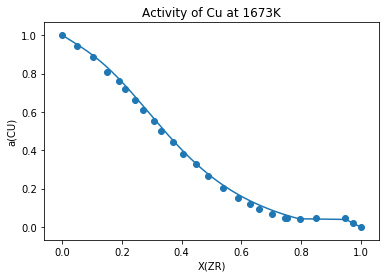

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(eq.X.sel(component='ZR', vertex=0).squeeze(), acr_cu)
plt.scatter(exp_x_zr, exp_acr_cu)
plt.xlabel('X(ZR)')
plt.ylabel('a(CU)')
plt.title('Activity of Cu at 1673K')